In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import pandas as pd
import sys
sys.path.append("/home/ws/oc9627/cerebral_organoid_quant_mri")

from scripts.utils.constants import MRI_ORG_LOC_GT_DIR, MRI_CYST_LOC_GT_DIR
from scripts.utils.segmentation_performance_extractor import SegmentationPerformanceExtractor
from scripts.utils.segmentation_overlay_visualizer import SegmentationOverlayVisualizer
from scripts.utils.io_utils import get_orig_imgs, get_masks
from scripts.utils.global_cyst_classification import get_compactness
from scripts.utils.metrics import calculate_roc_auc
from scripts.utils.dw_mri import get_metrics_global_cyst_seg_dw_mri

from scripts.utils.visualization import plot_compactness, plot_examples_lq_hq_organoids, plot_trace_lq_hq_mean_org_int, plot_correlation_compactness_cysticity, plot_organoid_growth_over_time
from scripts.utils.global_cyst_classification import get_all_otsu_masks, get_org_mean_and_compactness
from scripts.utils.constants import CSV_GLOBAL_CYST_ANNOT

wdir = '/home/ws/oc9627/cerebral_organoid_quant_mri'
os.chdir(wdir)

# Organoid segmentation

#### extract results on test set

In [2]:
pred_dir = 'results/organoid_segmentation/checkpoint_dirs_trained_previously/all_predictions_on_test_sets'
gt_dir = MRI_ORG_LOC_GT_DIR

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/segmentation_performance_extractor.py:49: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = self.df.drop_duplicates().mean()['Test Dice']
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/segmentation_performance_extractor.py:50: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sd = self.df.drop_duplicates().std()['Test Dice']


Test Dice 0.92±0.06 (mean±SD)


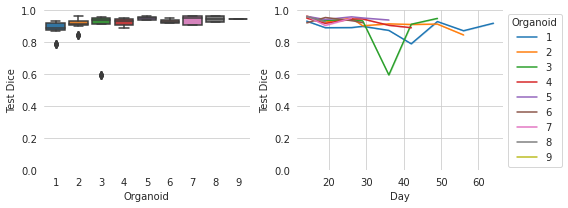

In [3]:
spe = SegmentationPerformanceExtractor(pred_dir = pred_dir,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance(save_to='results/organoid_segmentation/plots/organoid_seg_performance.png')
spe.print_test_dice_mean_sd()

#### plot weakest, intermediate and best prediction

In [4]:
imgs = get_orig_imgs(kind='mri')

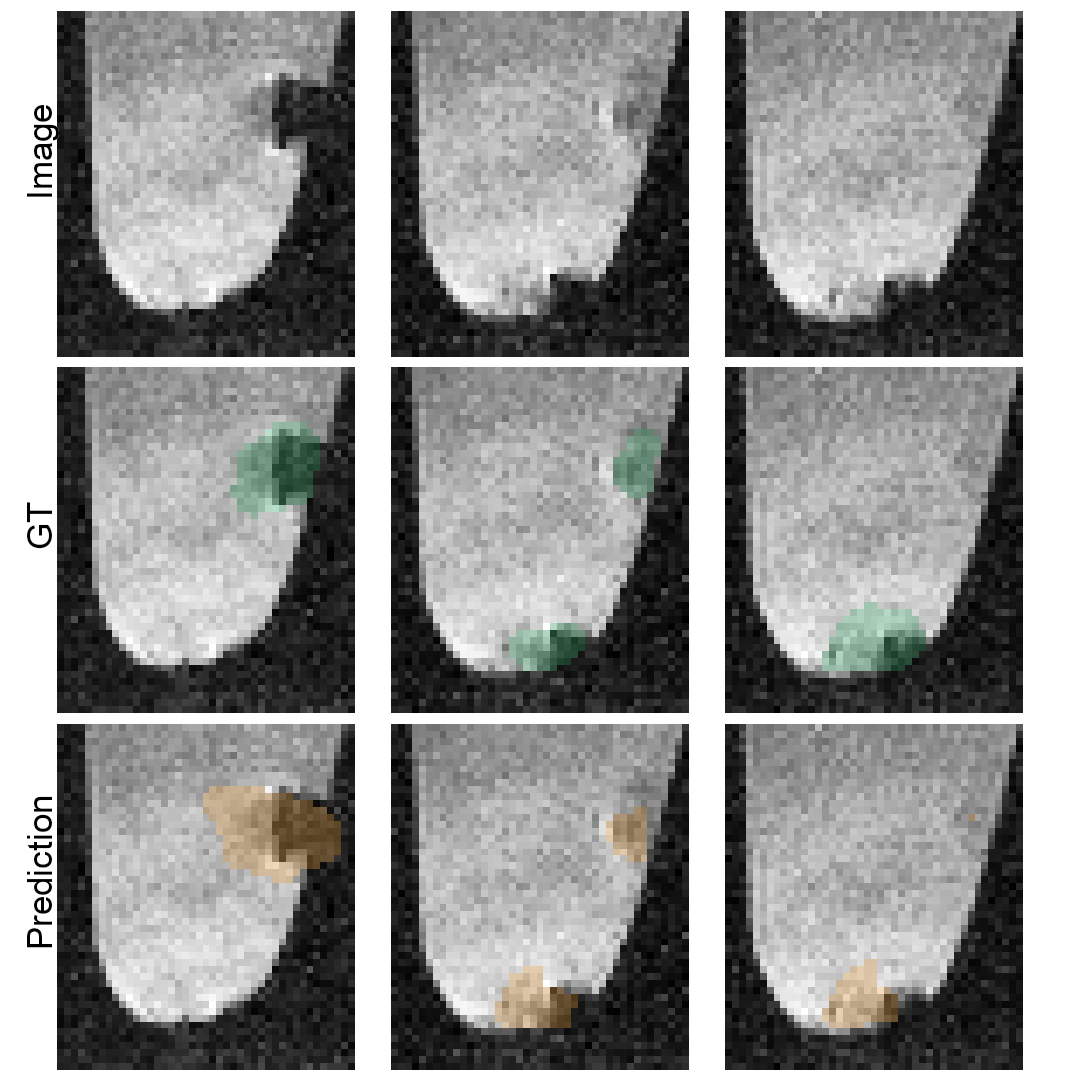

In [5]:
# weakest prediction
for pred_color in ['green', 'orange']:
    sov = SegmentationOverlayVisualizer(imgs,
                                    org_id = 'org3_0609', 
                                    org_loc = [15, 65, 65, 108], 
                                    gt_dir = MRI_ORG_LOC_GT_DIR,
                                    pred_dir = pred_dir,
                                    px_threshold=0,
                                    planes='sagittal',
                                    keep_planes=[44, 47, 50],
                                    rot_img=270,
                                    pred_color=pred_color,
                                    save_to=f'results/organoid_segmentation/plots/organoid_seg_overlay_org3_0609_pred-{pred_color}.png')
    sov.plot_segmentation_overlays()
display(sov.plot_segmentation_overlays())

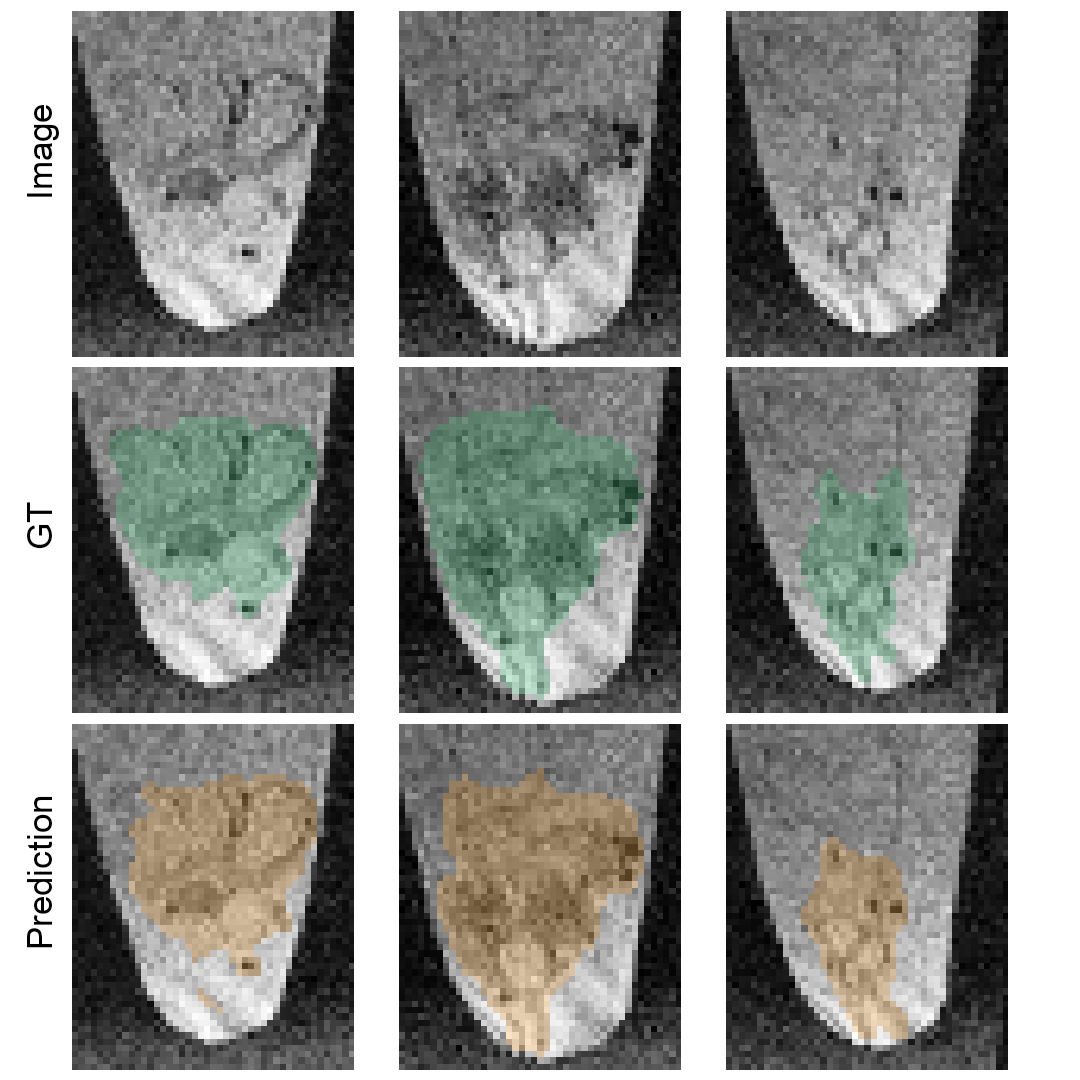

In [6]:
# intermediate prediction
for pred_color in ['green', 'orange']:
    sov = SegmentationOverlayVisualizer(imgs,
                                 org_id = 'org2_0615', 
                                 org_loc = [20, 75, 30, 75], 
                                 gt_dir = MRI_ORG_LOC_GT_DIR,
                                 pred_dir = pred_dir,
                                 px_threshold=0,
                                 planes='sagittal',
                                 keep_planes=[40, 50, 58],
                                 rot_img=270,
                                 pred_color=pred_color,
                                 save_to=f'results/organoid_segmentation/plots/organoid_seg_overlay_org2_0615_pred-{pred_color}.png')
    sov.plot_segmentation_overlays()
display(sov.plot_segmentation_overlays())

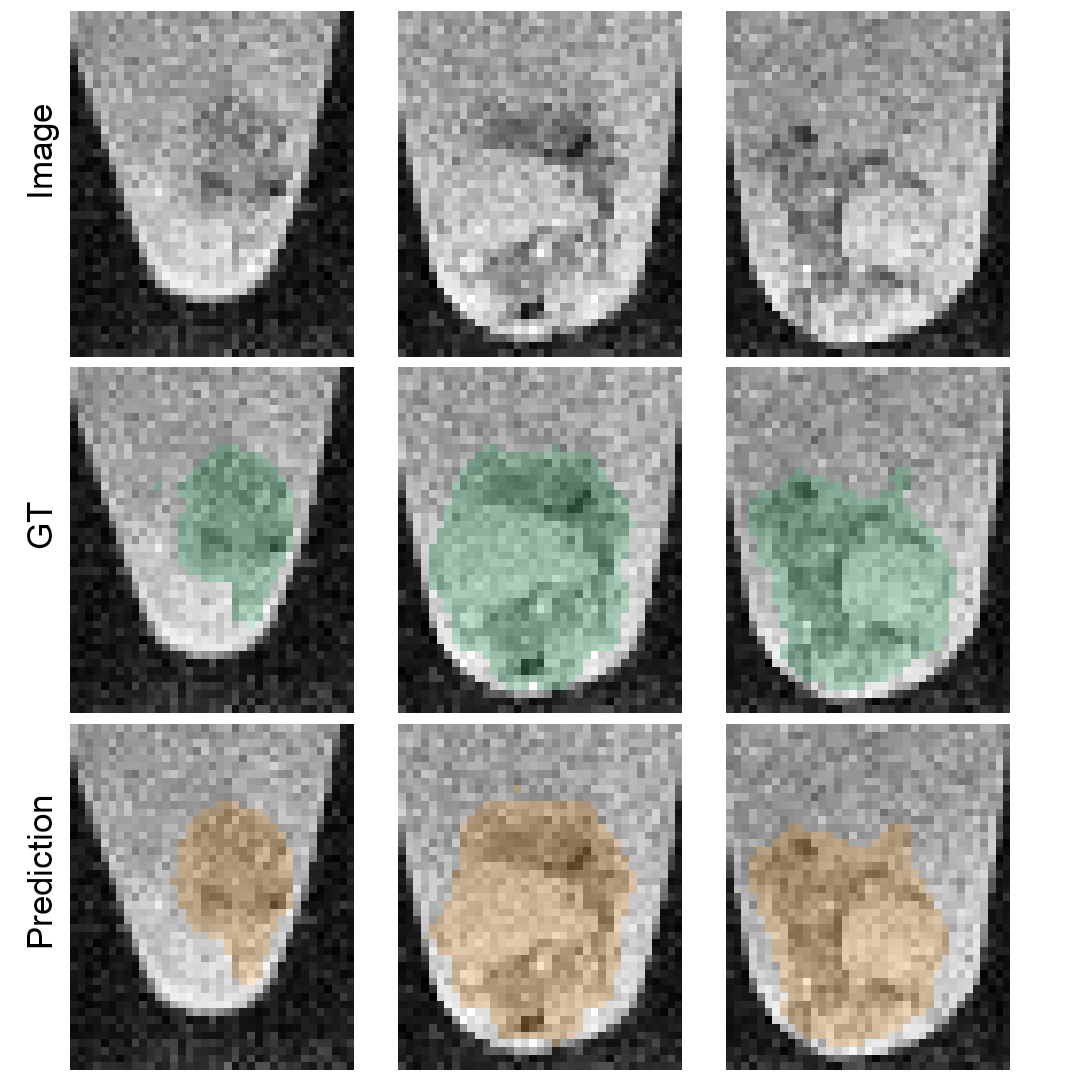

In [7]:
# strongest prediction
for pred_color in ['green', 'orange']:
    sov = SegmentationOverlayVisualizer(imgs,
                                     org_id = 'org5_0530', 
                                     org_loc = [20, 65, 38, 75], 
                                     gt_dir = MRI_ORG_LOC_GT_DIR,
                                     pred_dir = pred_dir,
                                     px_threshold=0,
                                     planes='sagittal',
                                     keep_planes=[34, 40, 52],
                                     rot_img=270,
                                     pred_color=pred_color,
                                     save_to=f'results/organoid_segmentation/plots/organoid_seg_overlay_org5_0530_pred-{pred_color}.png')
img = sov.plot_segmentation_overlays()
display(img)

# Global cyst classification

#### Calculate mean organoid intensities and compactness

In [8]:
df = get_compactness()

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:63: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.stack(np.array(eppendorf_masks)), 0, -1)
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.stack(np.array(eppendorf_masks)), 0, -1)


#### Calculate ROC AUC and visualize class separation

ROC AUC for mean organoid intensity:	0.64
ROC AUC for Compactness:		0.98


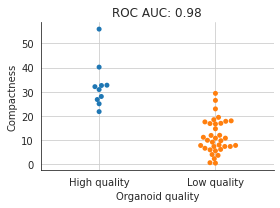

In [9]:
roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
roc_auc_compactness = calculate_roc_auc(df, col='compactness')

print(f'ROC AUC for mean organoid intensity:\t{roc_auc_moi}')
print(f'ROC AUC for Compactness:\t\t{roc_auc_compactness}')

plot_compactness(df, 
                 roc_auc_compactness, 
                 save_to='results/global_cyst_classification/compactness_separates_lq_hq_organoids.png')

#### Visualize examples of LQ and HQ organoids

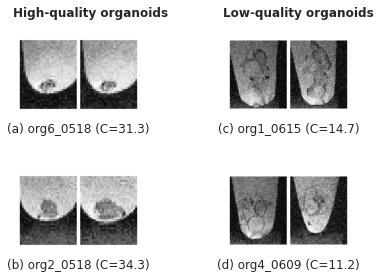

In [10]:
org_ids = ['org6_0518', 'org2_0518', 'org1_0615', 'org4_0609']
compactnesses = [31.3, 34.3, 14.7, 11.2]
# two selected sagittal planes for each organoid
# other ranges to crop images to EV boundaries for better visibility (manually extracted) 
org_locs_planes = [(['88-117', '59', '32-67'], ['88-117', '60', '32-67']),
                   (['40-69', '41', '40-75'], ['40-69', '45', '40-75']),
                   (['5-55', '58', '15-90'], ['5-55', '61', '15-90']),
                   (['17-67', '36', '15-85'], ['17-67', '53', '15-85'])]
plot_examples_lq_hq_organoids(org_ids, 
                              compactnesses,
                              org_locs_planes,
                              save_to='results/global_cyst_classification/examples_lq_hq_organoids.png')

#### DW-MRI to probe tissue characteristics

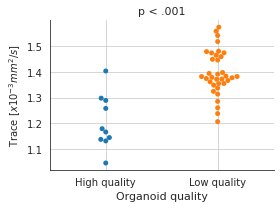

In [11]:
plot_trace_lq_hq_mean_org_int(save_to='results/global_cyst_classification/trace_mean_org_intensities.png')

# Local cyst classification

#### extract results

In [12]:
pred_dir_local_cysts = 'results/local_cyst_segmentation/checkpoint_dirs_trained_previously/all_predictions_on_test_sets'
gt_dir = MRI_CYST_LOC_GT_DIR

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/segmentation_performance_extractor.py:49: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = self.df.drop_duplicates().mean()['Test Dice']
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/segmentation_performance_extractor.py:50: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sd = self.df.drop_duplicates().std()['Test Dice']


Test Dice 0.63±0.15 (mean±SD)


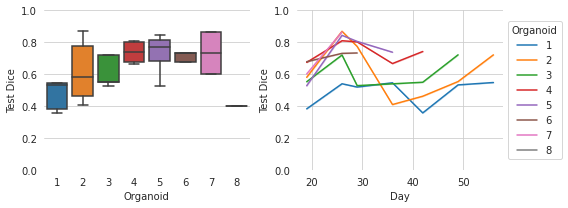

In [13]:
spe = SegmentationPerformanceExtractor(pred_dir = pred_dir_local_cysts,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance(save_to='results/local_cyst_segmentation/plots/local_cyst_seg_performance.png')
spe.print_test_dice_mean_sd()

#### visualize weakest, intermediate and strongest prediction

In [14]:
imgs = get_orig_imgs(kind='mri')

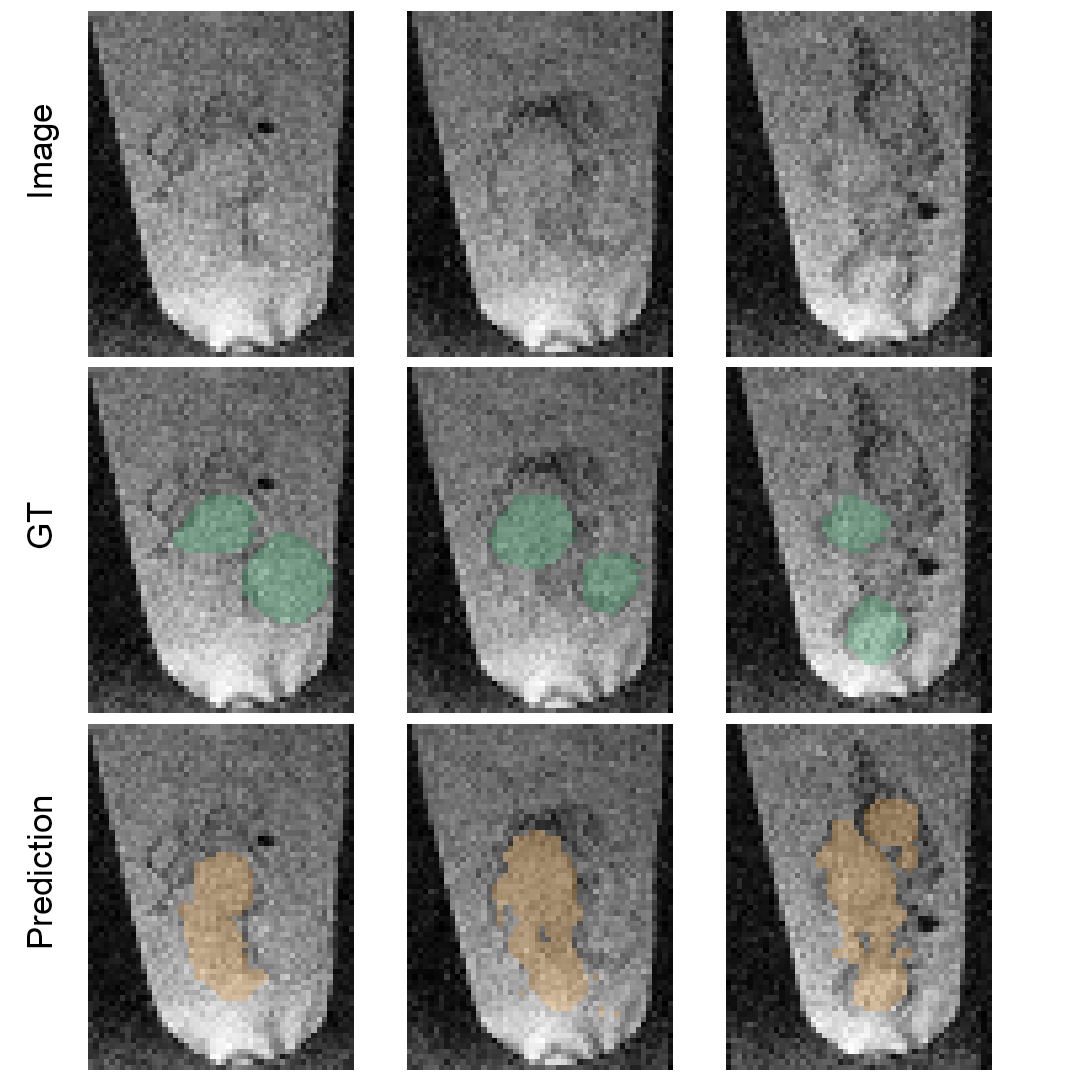

In [15]:
# weakest prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org1_0615', 
                 org_loc = [10, 75, 10, 60],
                 gt_dir = gt_dir,
                 pred_dir = pred_dir_local_cysts,
                 planes='sagittal',
                 keep_planes=[51, 55, 60],
                 rot_img=270,
                 pred_color='orange',
                 save_to='results/local_cyst_segmentation/plots/cyst_seg_overlay_org1_0615_pred-orange.png')
display(sov.plot_segmentation_overlays())

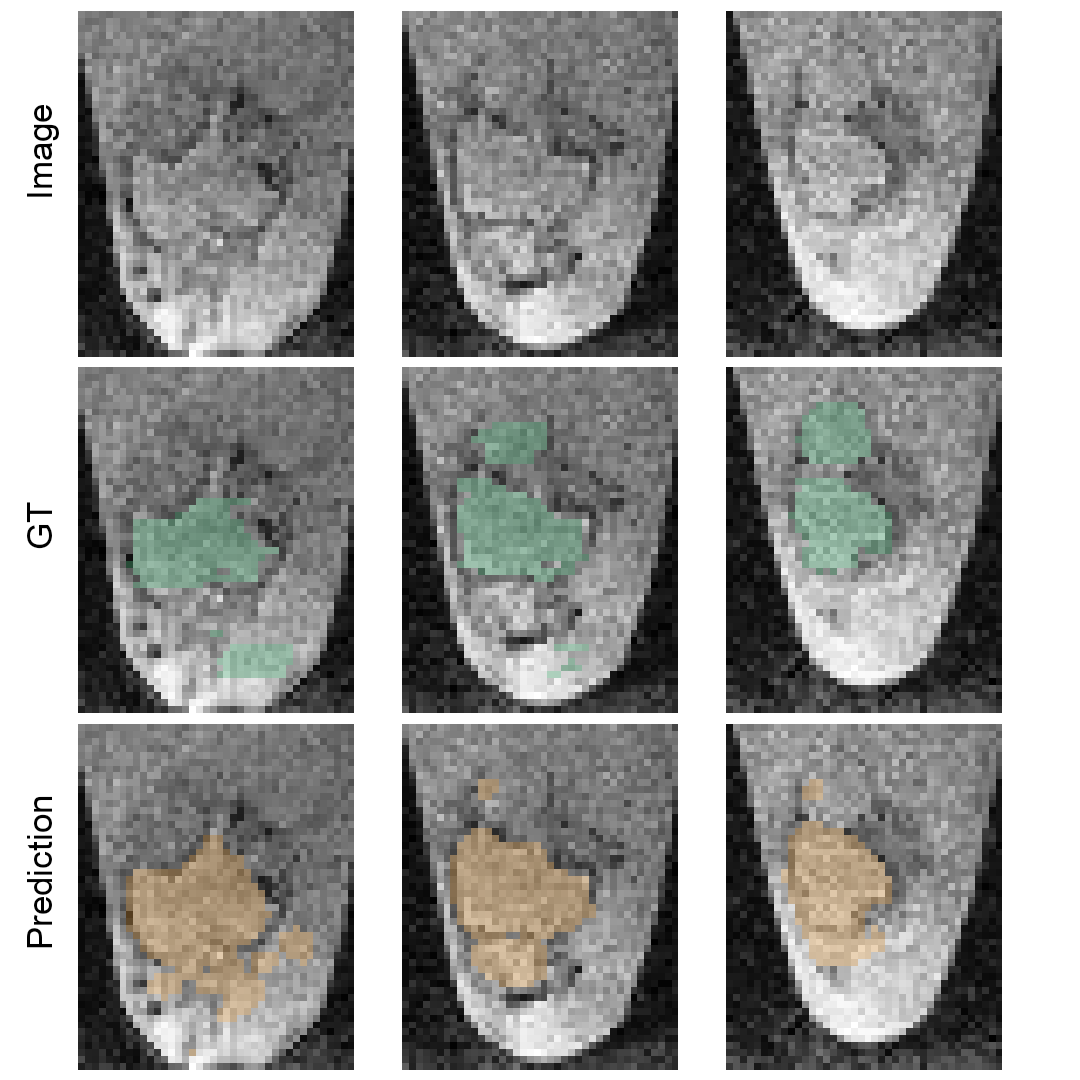

In [16]:
# intermediate prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org4_0609', 
                 org_loc=[20, 70, 25, 65], 
                 gt_dir = gt_dir,
                 pred_dir = pred_dir_local_cysts,
                 planes='sagittal',
                 px_threshold=0,
                 keep_planes=[42, 49, 52],
                 pred_color='orange',
                 rot_img=270,
                 save_to='results/local_cyst_segmentation/plots/cyst_seg_overlay_org4_0609_pred-orange.png')
display(sov.plot_segmentation_overlays())

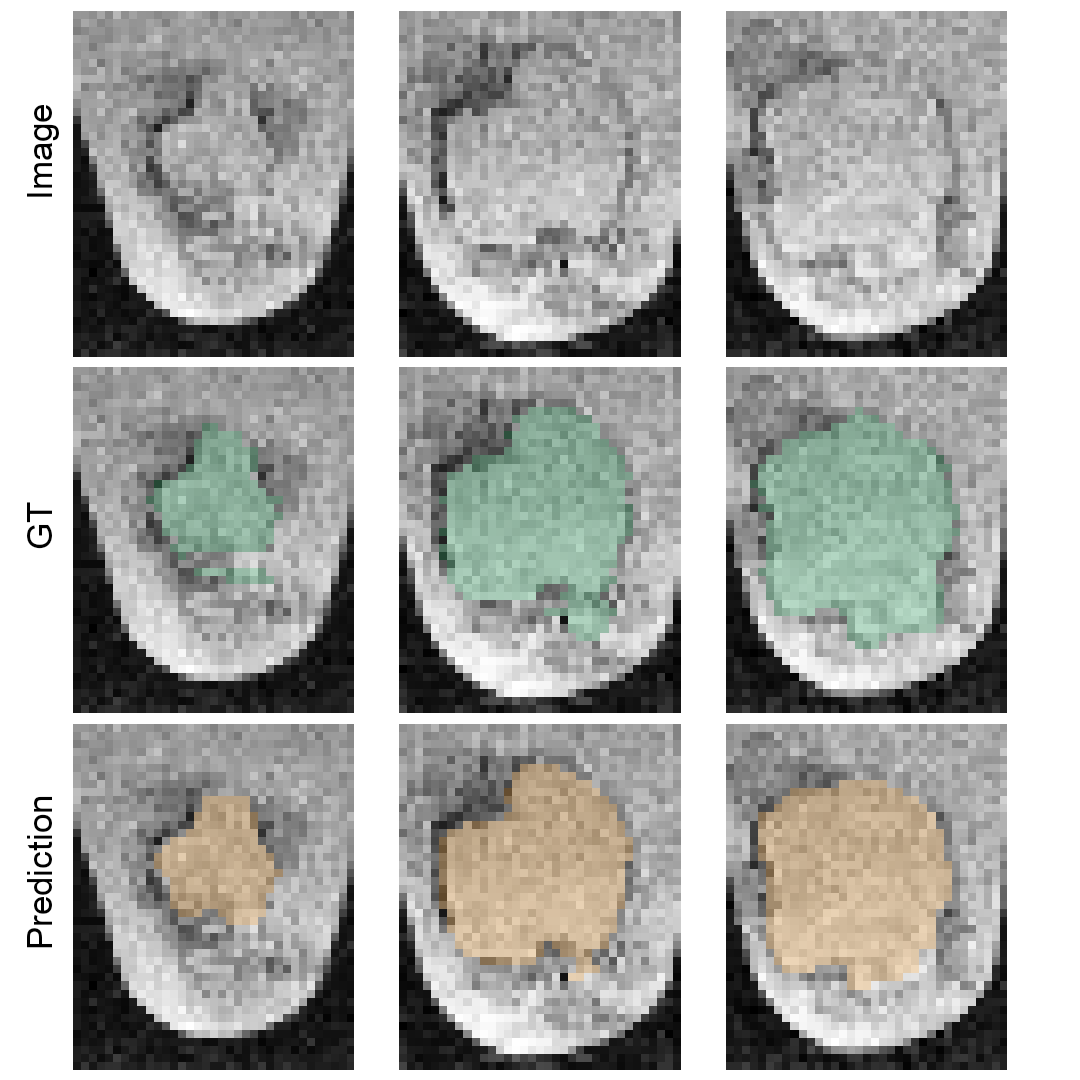

In [17]:
# strongest prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org7_0530', 
                 org_loc=[22, 65, 20, 55], 
                 gt_dir = MRI_CYST_LOC_GT_DIR,
                 pred_dir = pred_dir_local_cysts,
                 planes='sagittal',
                 px_threshold=0,
                 keep_planes=[49, 56, 63],
                 rot_img=270,
                 pred_color='orange',
                 save_to='results/local_cyst_segmentation/plots/cyst_seg_overlay_org7_0530_pred-orange.png')
display(sov.plot_segmentation_overlays())

# Supplementary

### organoid segmentation

#### plot organoid growth over time

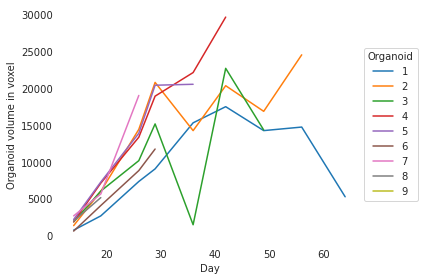

In [18]:
plot_organoid_growth_over_time()
plt.savefig('results/supplement/organoid_growth_over_time.png', dpi=400)

### global cyst classification

#### correlation of compactness with cysticity from local cyst segmentations

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:63: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.stack(np.array(eppendorf_masks)), 0, -1)
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.stack(np.array(eppendorf_masks)), 0, -1)


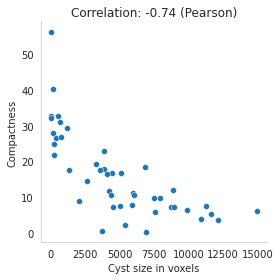

In [19]:
plot_correlation_compactness_cysticity(save_to='results/local_cyst_segmentation/plots/correlation_compactness_cysticity.png')

#### values for predicted organoid locations (3D U-Net)

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:63: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.stack(np.array(eppendorf_masks)), 0, -1)
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.stack(np.array(eppendorf_masks)), 0, -1)


ROC AUC for mean organoid intensity:	0.6485714285714286
ROC AUC for Compactness:		0.9514285714285714


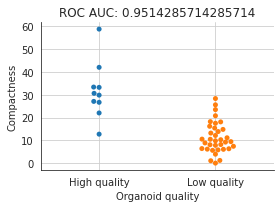

In [20]:
imgs = get_orig_imgs(kind='mri')
gt = get_masks(kind='predicted_org_loc')
otsu, _ = get_all_otsu_masks(imgs, gt)

df = get_org_mean_and_compactness(imgs, 
                                  org_loc=gt, 
                                  otsu=otsu)
quality_annot = pd.read_csv(CSV_GLOBAL_CYST_ANNOT)
df = df.merge(quality_annot)

roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
roc_auc_compactness = calculate_roc_auc(df, col='compactness')

print(f'ROC AUC for mean organoid intensity:\t{roc_auc_moi}')
print(f'ROC AUC for Compactness:\t\t{roc_auc_compactness}')

plot_compactness(df, roc_auc_compactness)

### ROC AUCs for DW-MRI

In [21]:
df_dwmri_metrics, _ = get_metrics_global_cyst_seg_dw_mri()
df_dwmri_metrics['ROC AUC'] = df_dwmri_metrics['ROC AUC'].map('{:,.2f}'.format)
df_dwmri_metrics['P-value'] = df_dwmri_metrics['P-value'].map('{:,.1E}'.format)
df_dwmri_metrics['P-value corr'] = df_dwmri_metrics['P-value corr'].map('{:,.1E}'.format)
df_dwmri_metrics
# df_dwmri_metrics.to_csv('metrics_global_cyst_seg_dwmri.csv', index=False, sep=';')

,DW-MRI sequence,ROC AUC,P-value,P-value corr
10,1st Eigenvalue,0.93,1.3E-06,2.1E-05
4,Tensor Component Dxx,0.91,3.3E-07,7.2E-06
5,Tensor Component Dyy,0.91,6.2E-07,1.2E-05
11,2nd Eigenvalue,0.91,6.5E-07,1.2E-05
1,Trace,0.91,5.1E-07,1.1E-05
6,Tensor Component Dzz,0.90,1.0E-06,1.8E-05
12,3rd Eigenvalue,0.86,3.9E-05,6.2E-04
3,Trace Weighted Image,0.75,8.9E-03,1.2E-01
18,2nd Eigenvector z,0.74,2.0E-03,3.0E-02
21,3rd Eigenvector z,0.68,1.8E-01,8.9E-01


### show for one plane how automatic ET voxel determination works

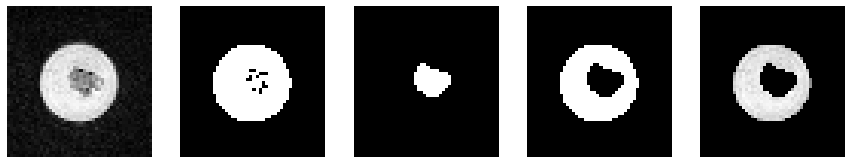

In [22]:
imgs = get_orig_imgs(kind='mri')
gts = get_masks(kind='gt_org_loc')

cor_plane = 60
img = imgs['org1_0518'][0:50, 10:58, cor_plane]
gt = gts['org1_0518'][0:50, 10:58, cor_plane]

cmap = plt.cm.get_cmap('Greys').reversed()
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
# otsu, _ = get_all_otsu_masks(imgs, gt)
axs[0].imshow(img, cmap=cmap)
otsu_seg = (img > threshold_otsu(img)).astype('bool')
axs[1].imshow(otsu_seg, cmap=cmap)
axs[2].imshow(gt, cmap=cmap)
# axs[1].imshow(img > threshold_otsu(img), cmap=cmap)
axs[3].imshow(np.where(otsu_seg & ~gt.astype('bool'), 1, 0), cmap=cmap)
axs[4].imshow(np.where(otsu_seg & ~gt.astype('bool'), img, 0), cmap=cmap)

axs[0].set_title
for i in range(5):
    axs[i].axis('off')